# Dataset and Feature importance analysis


In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import string
import time
import math
import os

import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from pathlib import Path

In [2]:
annotations_file1 = Path(r"../DVlog/dataset/dvlog_labels_v1.csv")
annotations_file2 = Path(r"../DVlog/dataset/dvlog_labels_v2.csv")
durations_file = Path(r"../data/dvlog_transcripts.xlsx")

pdem_features_path = Path(r"E:/master/data/PDEM/pdem-dataset")
text_embeddings_path = Path(r"E:/master/data/embeddings-dataset")

In [3]:
# load in both the annotation labels
df_annotv1 = pd.read_csv(annotations_file1)
df_annotv2 = pd.read_csv(annotations_file2)

df_annotv2.head()

,video_id,label,gender,dataset
0,0,1,f,train
1,1,1,f,test
2,2,1,m,train
3,3,1,m,train
4,4,1,f,test


## Descriptive statistics of the D-Vlog dataset

In [4]:
df_durations = pd.read_excel(durations_file)

# do the merge on video_id and duration
df_timev2 = pd.merge(df_annotv2, df_durations[["video_id", "duration"]], on="video_id", how="left")
df_timev2.head()

,video_id,label,gender,dataset,duration
0,0,1,f,train,823.31
1,1,1,f,test,436.65
2,2,1,m,train,835.83
3,3,1,m,train,420.61
4,4,1,f,test,444.55


In [5]:
df_timev2.groupby(["label", "gender"]).agg({"dataset": "count", "duration": "mean"})

dataset    duration
label gender                     
0     f           240  592.758625
      m           138  433.173841
1     f           302  650.870629
      m           147  569.487551

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


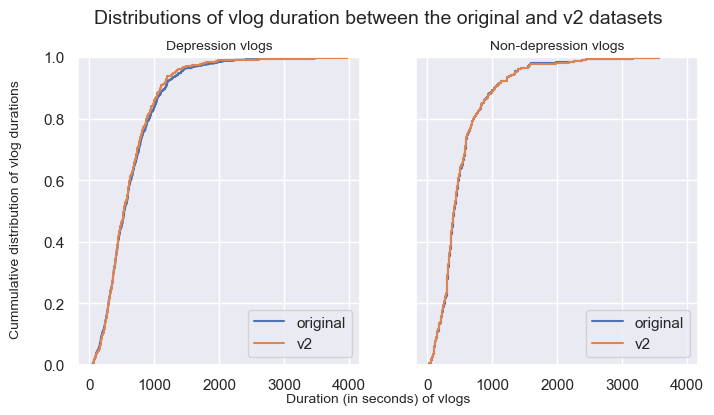

In [6]:
# plot both the cumulative distributions before and after filtering for both the labels
# get the durations of the original dataset
df_timev1 = pd.merge(df_annotv1, df_durations[["video_id", "duration"]], on="video_id", how="left")

title_size = 14
sup_title_size = 10

# build the plot
fig = plt.figure(figsize=(8, 4))
axs = fig.subplots(1, 2, sharex=True, sharey=True)

# plot the difference between the depressive original and v2
axs[0].set_title("Depression vlogs", size=sup_title_size)
axs[0].ecdf(df_timev1[df_timev1["label"] == 1]["duration"], label="original")
axs[0].ecdf(df_timev2[df_timev2["label"] == 1]["duration"], label="v2")
axs[0].legend(loc=4)

# plot the difference between the non-depressive original and v2
axs[1].set_title("Non-depression vlogs", size=sup_title_size)
axs[1].ecdf(df_timev1[df_timev1["label"] == 0]["duration"], label="original")
axs[1].ecdf(df_timev2[df_timev2["label"] == 0]["duration"], label="v2")
axs[1].legend(loc=4)

#
fig.supxlabel('Duration (in seconds) of vlogs', size=sup_title_size)
fig.supylabel('Cummulative distribution of vlog durations', size=sup_title_size, x=.04)
fig.suptitle("Distributions of vlog duration between the original and v2 datasets", size=title_size, y=1.0)

# save the figure and show it
plt.savefig("../figures/vlog_duration_dist.eps")
plt.show()

## Descriptive statistics of the train, test and validation sets

In [7]:
df_annotv1.groupby(["dataset", "gender"]).count()

video_id  label
dataset gender                 
test    f            127    127
        m             64     64
train   f            447    447
        m            225    225
val     f             65     65
        m             33     33

In [8]:
df_annotv2.groupby(["dataset", "gender"]).count()

video_id  label
dataset gender                 
test    f            108    108
        m             57     57
train   f            379    379
        m            199    199
val     f             55     55
        m             29     29

In [10]:
# get the distribution of the subgroups
df_annotv2[df_annotv2["dataset"] == "train"].groupby(["label", "gender"]).count()

video_id  dataset
label gender                   
0     f            168      168
      m             96       96
1     f            211      211
      m            103      103

## Retrieve information regarding the PDEM features

In [ ]:
pdem_info_dict = {}

for index, row in df_annotations.iterrows():

    video_id = str(row.video_id)
    vad_file_path = os.path.join(pdem_features_path, video_id, "pdemvad.npy")
    embeddings = np.load(vad_file_path).astype(np.float32)

    # save the info
    pdem_info_dict[video_id] = {
        "embedding": embeddings,
        "seq_length": embeddings.shape[0],
        "arousal": 1,
        "dominance": 1,
        "valence": 1
    }

In [ ]:
# put the information back into the dataframe
df_annotations["pdem_seq_length"] = df_annotations["video_id"].apply(lambda x: pdem_info_dict.get(str(x)).get("seq_length"))

print(f"mean length: {df_annotations['pdem_seq_length'].mean()}\nmax length: {df_annotations['pdem_seq_length'].max()}")

df_annotations.head()

In [ ]:
# Get the distribution for both the male and female extracted features
plt.figure()

# plot the data
sns.displot(df_annotations, x="pdem_seq_length", hue="gender", kind="kde")

# plot the vertical mean line
x_mean = df_annotations['pdem_seq_length'].mean()
plt.axvline(x_mean, color='r', ls='--', label=f"μ pdem")

plt.legend()
plt.show()

## Retrieve and plot information regarding the word and sentence embeddings

In [ ]:
embed_info_dict = {}

for index, row in df_annotations.iterrows():

    video_id = str(row.video_id)
    embeddings_file_path = os.path.join(text_embeddings_path, video_id)
    embed_info_dict[video_id] = {
        "w2v_seconds": np.load(os.path.join(embeddings_file_path, "w2v_seconds_normal_avg.npy")).astype(np.float32).shape[0],
        "w2v_sentences": np.load(os.path.join(embeddings_file_path, "w2v_seq_avg.npy")).astype(np.float32).shape[0],
        "w2v_keywords": np.load(os.path.join(embeddings_file_path, "w2v_seq_avg_keyw.npy")).astype(np.float32).shape[0]
    }

In [ ]:
# put the features back into the dataframe
df_annotations["w2v_seconds"] = df_annotations["video_id"].apply(lambda x: embed_info_dict.get(str(x)).get("w2v_seconds"))
df_annotations["w2v_sentences"] = df_annotations["video_id"].apply(lambda x: embed_info_dict.get(str(x)).get("w2v_sentences"))
df_annotations["w2v_keywords"] = df_annotations["video_id"].apply(lambda x: embed_info_dict.get(str(x)).get("w2v_keywords"))

df_annotations.head()

In [ ]:
# Get the distribution for both the male and female extracted features
mean_length = round(df_annotations['w2v_seconds'].mean(), 2)
print(f"mean length: {mean_length}")

plt.figure()

# plot the data
sns.displot(df_annotations, x="w2v_seconds", hue="gender", kind="kde")

# plot the vertical mean line
x_mean = df_annotations['w2v_seconds'].mean()
plt.axvline(x_mean, color='r', ls='--', label=f"μ vlogs={mean_length}")

plt.legend()
plt.show()

In [ ]:
# get the length of the sentences with the mean per label and overall
mean_length = round(df_annotations['w2v_sentences'].mean(), 2)
gender_length = df_annotations.groupby(["gender"]).agg(avg_duration=("w2v_sentences", "mean"))
f_length, m_length = round(gender_length.loc["f"]["avg_duration"], 2), round(gender_length.loc["m"]["avg_duration"], 2)
print(gender_length)
# plot the figure
plt.figure()

# plot the data
sns.displot(df_annotations, x="w2v_sentences", hue="gender", kind="kde")

# plot the vertical mean line
plt.axvline(mean_length, color='r', ls='--', label=f"μ vlogs={mean_length}")
plt.axvline(m_length, color='k', ls='-', label=f"μ male vlogs={m_length}")
plt.axvline(f_length, color='m', ls='-', label=f"μ female vlogs={f_length}")

plt.legend()
plt.show()

In [ ]:
# get the length of the sentences with the mean per label and overall
norm_length, keyw_length = round(df_annotations['w2v_sentences'].mean(), 2), round(df_annotations['w2v_keywords'].mean(), 2)

# plot the data
plt.figure()

sns.displot([df_annotations["w2v_sentences"], df_annotations["w2v_keywords"]], kind="kde")
# sns.displot(df_annotations, x="w2v_keywords", kind="kde")

# plot the vertical mean line
plt.axvline(norm_length, color='r', ls='--', label=f"μ before={norm_length}")
plt.axvline(keyw_length, color='k', ls='-', label=f"μ after={keyw_length}")

plt.legend()
plt.show()